## Install `fasterai`


In [1]:
!pip install git+https://github.com/nathanhubens/fasterai.git
!pip install git+https://github.com/nathanhubens/CUTE22.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/nathanhubens/fasterai.git to /tmp/pip-req-build-743efpa3
  Running command git clone -q https://github.com/nathanhubens/fasterai.git /tmp/pip-req-build-743efpa3
  Created wheel for fasterai: filename=fasterai-0.1.9-py3-none-any.whl size=21311 sha256=c6f64f031a5fd8c6e0e7a075ffbe8e8951861bee3b88301ac2e1493c4f03187b
  Stored in directory: /tmp/pip-ephem-wheel-cache-rfoy5wms/wheels/5e/e5/6d/0752d90e4fa5c28b88bdb877fce0ddb9384d40fa5d30cc29a9
Successfully built fasterai
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/nathanhubens/CUTE22.git to /tmp/pip-req-build-8tdcmmbj
  Running command git clone -q https://github.com/nathanhubens/CUTE22.git /tmp/pip-req-build-8tdcmmbj
  Created wheel for cute: filename=cute-0.0.1-py3-none-any.whl size=2346 sha256=902eabc72471323e074ec900b6f3f0e5f663f6

## Import librairies

In [2]:
from fastai.vision.all import *
from fasterai.sparse.all import *
from cute.utils import *

## Get Data

In [3]:
path = untar_data(URLs.PETS) 
files = get_image_files(path/"images")

def label_func(f): return f[0].isupper()

dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(64))

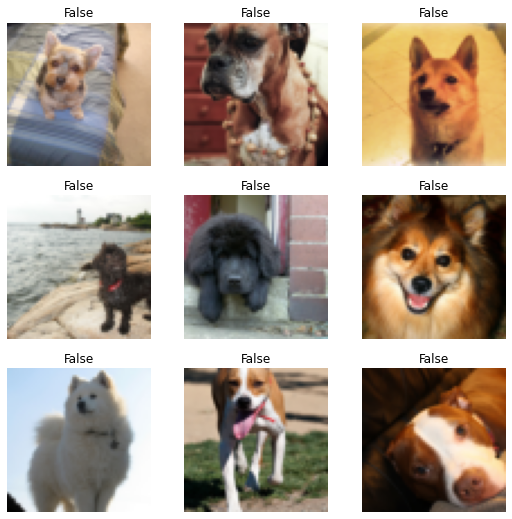

In [4]:
dls.show_batch()

## Create Network

In [5]:
learn = Learner(dls, resnet18(num_classes=2), metrics=accuracy)

## Get Baseline

In [6]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.619230,0.584085,0.692152,00:40
1,0.561093,0.626173,0.658322,00:39
2,0.505177,0.481566,0.766576,00:39
3,0.439723,0.443404,0.794993,00:39
4,0.359629,0.392948,0.819350,00:38


## Create `Callback`

In [7]:
sp_cb = SparsifyCallback(sparsity=50, granularity='weight', context='local', criteria=large_final, schedule=cos)

## Make it sparse !

In [8]:
learn = Learner(dls, resnet18(num_classes=2), metrics=accuracy)
learn.fit_one_cycle(5, cbs=sp_cb)

Pruning of weight until a sparsity of [50]%
Saving Weights at epoch 0


epoch,train_loss,valid_loss,accuracy,time
0,0.620915,0.603408,0.669824,00:39
1,0.573005,0.547741,0.711773,00:39
2,0.522450,0.500715,0.742219,00:39
3,0.464592,0.435795,0.790257,00:39
4,0.384151,0.397917,0.811908,00:39


Sparsity at the end of epoch 0: [4.77]%
Sparsity at the end of epoch 1: [17.27]%
Sparsity at the end of epoch 2: [32.73]%
Sparsity at the end of epoch 3: [45.23]%
Sparsity at the end of epoch 4: [50.0]%
Final Sparsity: [50.0]%
Sparsity in Conv2d 1: 50.00%
Sparsity in Conv2d 7: 50.00%
Sparsity in Conv2d 10: 50.00%
Sparsity in Conv2d 13: 50.00%
Sparsity in Conv2d 16: 50.00%
Sparsity in Conv2d 20: 50.00%
Sparsity in Conv2d 23: 50.00%
Sparsity in Conv2d 26: 50.00%
Sparsity in Conv2d 29: 50.00%
Sparsity in Conv2d 32: 50.00%
Sparsity in Conv2d 36: 50.00%
Sparsity in Conv2d 39: 50.00%
Sparsity in Conv2d 42: 50.00%
Sparsity in Conv2d 45: 50.00%
Sparsity in Conv2d 48: 50.00%
Sparsity in Conv2d 52: 50.00%
Sparsity in Conv2d 55: 50.00%
Sparsity in Conv2d 58: 50.00%
Sparsity in Conv2d 61: 50.00%
Sparsity in Conv2d 64: 50.00%


### Plot pruned weights

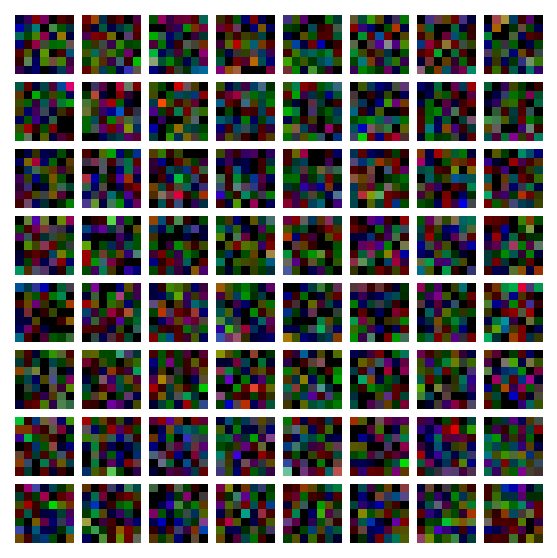

In [9]:
plot_kernels(learn.model.conv1.weight)

In [10]:
available_granularities()

Layer Type: Conv2d
Granularities: ['weight', 'shared_weight', 'channel', 'column', 'row', 'kernel', 'filter', 'shared_channel', 'shared_column', 'shared_row', 'vertical_slice', 'horizontal_slice', 'shared_vertical_slice', 'shared_horizontal_slice', 'shared_kernel', 'layer']


Layer Type: QuantConv2d
Granularities: ['weight', 'shared_weight', 'channel', 'column', 'row', 'kernel', 'filter', 'shared_channel', 'shared_column', 'shared_row', 'vertical_slice', 'horizontal_slice', 'shared_vertical_slice', 'shared_horizontal_slice', 'shared_kernel', 'layer']


Layer Type: Linear
Granularities: ['weight', 'column', 'row', 'layer']


Layer Type: Conv1D
Granularities: ['weight', 'column', 'row', 'layer']




In [11]:
available_criterias()

('random', 'large_final', 'small_final', 'squared_final', 'small_init', 'small_final', 'large_init_large_final', 'small_init_small_final', 'magnitude_increase', 'movement', 'updating_magnitude_increase', 'updating_movement', 'updating_movmag')


In [12]:
available_schedules()

('one_shot', 'iterative', 'one_cycle', 'cos', 'lin', 'dsd')


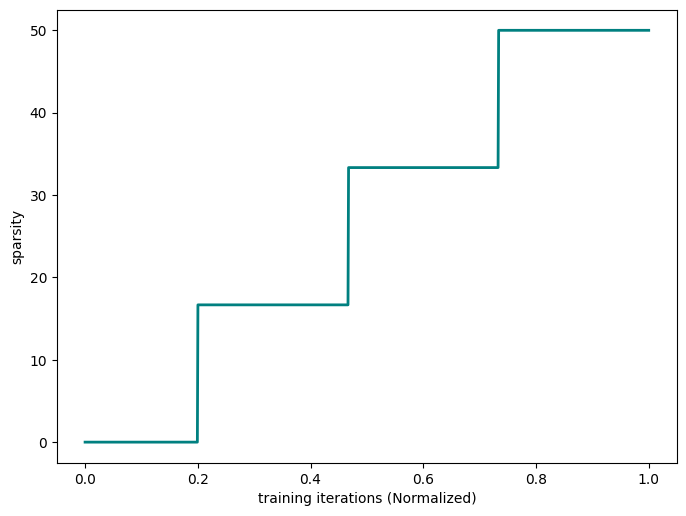

In [13]:
# schedules can be plotted !
iterative.plot(50)

To create a pruning schedule, we need 3 important things:
- The `sched_func`, i.e. the global shape of how sparsity evolves during training
- The `start_pct`, i.e. the starting iteration point
- The `end_pct`, i.e. the stopping iteration point

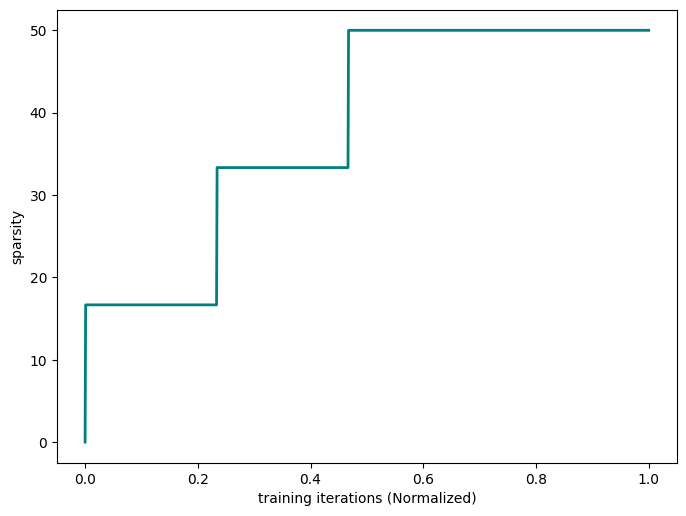

In [14]:
my_sched = Schedule(sched_func=sched_iterative, start_pct=0., end_pct=0.7)
my_sched.plot(50)

### Example Custom Schedule

In [15]:
def custom_sched(start, end, pos):
  return start+(end-start)*math.sqrt(pos)

In [16]:
my_sched = Schedule(sched_func=custom_sched, start_pct=0.2, end_pct=0.9)

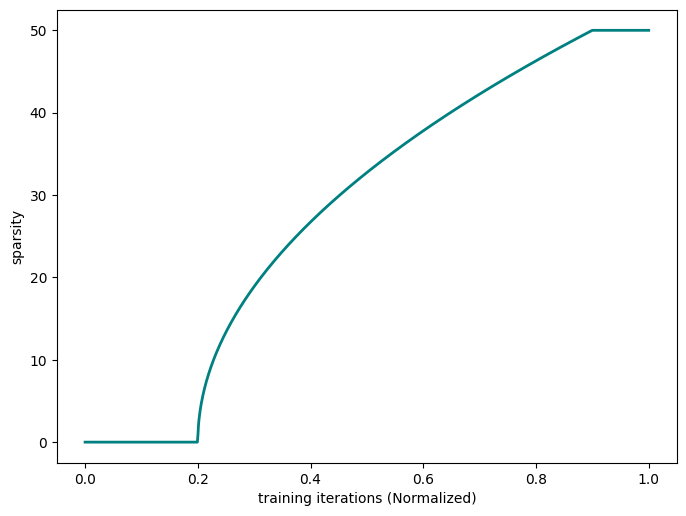

In [17]:
my_sched.plot(50)

## Do it yourselves !

★☆☆ Choose another [granularity](https://nathanhubens.github.io/fasterai/granularity.html) and retrain the model. How does the accuracy behave ? Why ?

★★☆ Change the schedule to mimic One-Shot Pruning.

★★★ Create your own schedule and test it.

---

## Challenge #1

★★★ Try to find the best combination of parameters

Requirements: 
- Model: ResNet18
- 5 epochs training
- 50% sparsity

---

## Knowledge Distillation

In [5]:
teacher = Learner(dls, resnet34(pretrained=True), metrics=accuracy)
teacher.model.fc = nn.Linear(512, 2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [6]:
teacher.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.411300,0.281989,0.867388,00:41
1,0.245782,0.196515,0.918809,00:41
2,0.111429,0.163074,0.940460,00:40


## Using KD

### On Logits

In [7]:
from fasterai.distill.all import *

In [8]:
student1 = Learner(dls, resnet18(num_classes=2), metrics=accuracy)

In [9]:
kd = KnowledgeDistillationCallback(teacher.model, SoftTarget, weight=0.5)

In [10]:
student1.fit_one_cycle(5, cbs=kd)

epoch,train_loss,valid_loss,accuracy,time
0,1.708902,3.520111,0.696211,00:41
1,1.551569,1.262429,0.769959,00:42
2,1.295254,1.461168,0.738836,00:41
3,0.980335,0.904174,0.820027,00:41
4,0.713473,0.807664,0.836265,00:41


### On Features

In [11]:
get_model_layers(teacher)

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer1.0',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.relu',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.1',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.relu',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer1.2',
 'layer1.2.conv1',
 'layer1.2.bn1',
 'layer1.2.relu',
 'layer1.2.conv2',
 'layer1.2.bn2',
 'layer2',
 'layer2.0',
 'layer2.0.conv1',
 'layer2.0.bn1',
 'layer2.0.relu',
 'layer2.0.conv2',
 'layer2.0.bn2',
 'layer2.0.downsample',
 'layer2.0.downsample.0',
 'layer2.0.downsample.1',
 'layer2.1',
 'layer2.1.conv1',
 'layer2.1.bn1',
 'layer2.1.relu',
 'layer2.1.conv2',
 'layer2.1.bn2',
 'layer2.2',
 'layer2.2.conv1',
 'layer2.2.bn1',
 'layer2.2.relu',
 'layer2.2.conv2',
 'layer2.2.bn2',
 'layer2.3',
 'layer2.3.conv1',
 'layer2.3.bn1',
 'layer2.3.relu',
 'layer2.3.conv2',
 'layer2.3.bn2',
 'layer3',
 'layer3.0',
 'layer3.0.conv1',
 'layer3.0.bn1',
 'layer3.0.relu',
 'layer3.0.conv2',
 'layer3.0.bn2',
 'layer3.0.downsample',
 'la

In [12]:
student2 = Learner(dls, resnet18(num_classes=2), metrics=accuracy)

In [13]:
kd = KnowledgeDistillationCallback(teacher.model, Attention, ['layer1', 'layer2'], ['layer1', 'layer2'], weight=0.9)

In [14]:
student2.fit_one_cycle(5, cbs=[kd])

epoch,train_loss,valid_loss,accuracy,time
0,0.062357,0.058672,0.707713,00:41
1,0.057849,0.061150,0.705007,00:41
2,0.052669,0.055029,0.724628,00:41
3,0.045879,0.044498,0.797023,00:41
4,0.036909,0.044197,0.809202,00:42


### Take a look at the results

In [15]:
x,y = dls.one_batch()

In [16]:
ix = 3
layer_name = 'layer1'

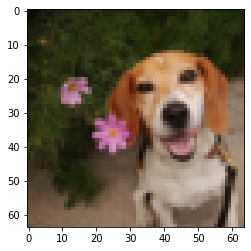

In [17]:
plt.imshow(x[0].squeeze().permute(1,2,0).cpu().detach())

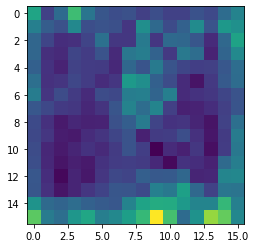

In [19]:
plot_activation(teacher, layer_name, x[ix])

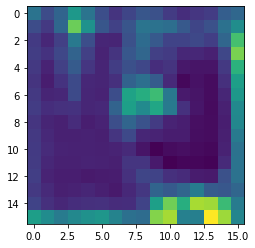

In [20]:
plot_activation(student1, layer_name, x[ix])

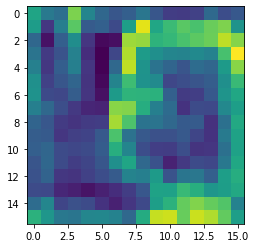

In [21]:
plot_activation(student2, layer_name, x[ix])

## Do it yourselves !

★☆☆ Change the KD weight to 0, then to 1. How does the accuracy behave ? Why ?

★★☆ Change the [loss](https://nathanhubens.github.io/fasterai/knowledge_distillation.html#Logits). How does the accuracy behave ?

★★☆ Try the Attention loss with a different combination of teacher/student layers

Challenge#2: Try to find the best combination of parameters with additional KD

Requirements: 
- Model: ResNet18
- Teacher: ResNet34
- 5 epochs training

Challenge #3: Combine Sparsify and KD to find the optimal network:

Requirements:
- Model: ResNet18
- Teacher: ResNet34
- 5 epochs training
- 50% sparsity

In [23]:
sp_cb = SparsifyCallback(sparsity=50, granularity='weight', context='local', criteria=large_final, schedule=cos)
kd = KnowledgeDistillationCallback(teacher.model, Attention, ['layer1', 'layer2'], ['layer1', 'layer2'], weight=0.9)

In [ ]:
teacher.model.cuda();

In [25]:
learn = Learner(dls, resnet18(num_classes=2), metrics=accuracy)
learn.fit_one_cycle(5, cbs=[sp_cb, kd])

Pruning of weight until a sparsity of [50]%
Saving Weights at epoch 0


epoch,train_loss,valid_loss,accuracy,time
0,0.064212,0.071021,0.685386,00:43
1,0.058646,0.058858,0.682003,00:42
2,0.053396,0.054167,0.731394,00:41
3,0.047553,0.047298,0.793640,00:42
4,0.038772,0.046107,0.794317,00:41


Sparsity at the end of epoch 0: [4.77]%
Sparsity at the end of epoch 1: [17.27]%
Sparsity at the end of epoch 2: [32.73]%
Sparsity at the end of epoch 3: [45.23]%
Sparsity at the end of epoch 4: [50.0]%
Final Sparsity: [50.0]%
Sparsity in Conv2d 1: 50.00%
Sparsity in Conv2d 7: 50.00%
Sparsity in Conv2d 10: 50.00%
Sparsity in Conv2d 13: 50.00%
Sparsity in Conv2d 16: 50.00%
Sparsity in Conv2d 20: 50.00%
Sparsity in Conv2d 23: 50.00%
Sparsity in Conv2d 26: 50.00%
Sparsity in Conv2d 29: 50.00%
Sparsity in Conv2d 32: 50.00%
Sparsity in Conv2d 36: 50.00%
Sparsity in Conv2d 39: 50.00%
Sparsity in Conv2d 42: 50.00%
Sparsity in Conv2d 45: 50.00%
Sparsity in Conv2d 48: 50.00%
Sparsity in Conv2d 52: 50.00%
Sparsity in Conv2d 55: 50.00%
Sparsity in Conv2d 58: 50.00%
Sparsity in Conv2d 61: 50.00%
Sparsity in Conv2d 64: 50.00%
